# Chapter 2: Feature Engineering

Believe it or not, this is where **I spend most of my time...** Between the simplicity of coding new features and the complexity of finding them. Your features reflect your understanding of the asset/market you want to trade; you can't limit yourself to 10 features for all your models.  

- **Features are like oil for your car**... You can't go anywhere without it (even if you have the latest Ferrari).  
- **Features are your boxing training sessions**... and creating the model is the championship fight. You can't win the belt without hours of preparation.  
- **Features are like water for humans**... You need them to survive.  

I think you understood what I wanted to say here: if you don't spend enough time on this part (50%-60% of the whole project), your project has a huge risk of failing.  
One last analogy for the road: **features are the foundations of your model**. You need to have them straight and solid to build something reliable on top of them.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ta
from hurst import compute_Hc
import seaborn as sns
from FeaturesLibrary import *
sns.set_style("whitegrid")

In [2]:
# Import all the data
df_1 = pd.read_parquet("DATA/EURUSD_1min_part1.parquet")
df_2 = pd.read_parquet("DATA/EURUSD_1min_part2.parquet")
df_3 = pd.read_parquet("DATA/EURUSD_1min_part3.parquet")

# Combine the sub-datasets into one dataframe
df = pd.concat((df_1, df_2, df_3), axis=0)

df

,open,high,low,close,tick_volume
time,,,,,
2014-11-13 23:00:00,1.24771,1.24775,1.24754,1.24765,133
2014-11-13 23:01:00,1.24766,1.24766,1.24763,1.24763,11
2014-11-13 23:02:00,1.24762,1.24763,1.24754,1.24754,19
2014-11-13 23:03:00,1.24754,1.24770,1.24754,1.24769,36
2014-11-13 23:04:00,1.24768,1.24768,1.24766,1.24768,33
...,...,...,...,...,...
2024-11-13 22:56:00,1.05590,1.05597,1.05585,1.05595,33
2024-11-13 22:57:00,1.05594,1.05604,1.05592,1.05602,20
2024-11-13 22:58:00,1.05602,1.05619,1.05601,1.05619,30


<br>

### 2.1. Intra-Bar Features

The **intra-bar features** (a name I came up with myself, as I couldn't find a conventional one online) are features focusing on the shortest variations: the variations **within** the candles you are using. They help you detect the latest information in the price.  

For example, if you are using a 4H timeframe, you might observe several scenarios: a huge spike, a decrease in price, or a ranging price. <br> 

Of course, these features are amazing for trading signals that focus on short-term variations or probabilities of reversal... but they are **useless for signals focusing on the market regime**, for instance. So, choose your features carefully!  

In [6]:
# Aggregate data into 4-hour intervals and add additional columns
data_4h = df.resample('4H').agg(
    open = ('open', 'first'),
    high = ('high', 'max'),
    low = ('low', 'min'),
    close = ('close', 'last'),
    tick_volume = ('tick_volume', 'sum'),
    high_time=('high', lambda x: x.idxmax() if len(x) > 0 else None),
    low_time=('low', lambda x: x.idxmin() if len(x) > 0 else None)
)

data_4h

,open,high,low,close,tick_volume,high_time,low_time
time,,,,,,,
2014-11-13 20:00:00,1.24771,1.24792,1.24740,1.24752,2017,2014-11-13 23:20:00,2014-11-13 23:48:00
2014-11-14 00:00:00,1.24750,1.24789,1.24588,1.24665,14537,2014-11-14 00:12:00,2014-11-14 03:09:00
2014-11-14 04:00:00,1.24665,1.24669,1.24266,1.24307,17128,2014-11-14 04:00:00,2014-11-14 07:46:00
2014-11-14 08:00:00,1.24306,1.24711,1.24262,1.24623,35033,2014-11-14 10:34:00,2014-11-14 08:04:00
2014-11-14 12:00:00,1.24614,1.24686,1.23982,1.24140,41784,2014-11-14 12:02:00,2014-11-14 15:36:00
...,...,...,...,...,...,...,...
2024-11-13 04:00:00,1.06277,1.06290,1.06092,1.06127,3868,2024-11-13 04:00:00,2024-11-13 07:22:00
2024-11-13 08:00:00,1.06127,1.06295,1.05931,1.06266,7587,2024-11-13 11:55:00,2024-11-13 10:09:00
2024-11-13 12:00:00,1.06265,1.06539,1.06097,1.06362,12339,2024-11-13 15:30:00,2024-11-13 13:31:00


In [4]:
data_4h.to_parquet("DATA/EURUSD_4H.parquet", engine='fastparquet', compression="gzip")

<br>

##### 2.1.1 **Hurst Exponent**

The Hurst exponent (H) is a statistical measure used to assess the degree of randomness or trend persistence in a time series. It is widely applied in trading and finance to evaluate the behavior of asset prices or other financial data over time.

- **Mean-reverting (0 < H < 0.5)**: The series tends to reverse to its mean over time (ideal for mean-reversion strategies, e.g., pairs trading).
- **Random Walk (H ≈ 0.5)**: The series behaves like a Brownian motion with no memory of past movements (indicates a lack of predictability).
- **Trending (0.5 < H < 1)**: The series exhibits long-term persistence or trends (useful for trend-following strategies, e.g., momentum trading).

*PS: You need to have a number of data points greater than or equal to 100 observations to use the Hurst function.*


In [5]:
# Extract the close price 
sr = df.iloc[0:190,:]["close"]

# Apply the Hurst Function (the first output value is the H value, we will not look to the others
compute_Hc(sr, kind='price')

(0.46715914862559427,
 1.164311339929652,
 [[10, 17, 31, 56, 100, 177, 190],
  [3.626918939650071,
   4.227356922605386,
   6.018077792518017,
   7.488342403095864,
   8.100355723349828,
   11.947645177659071,
   17.44324579993003]])

In [4]:
# Function to calculate the Hurst exponent of a time series
def hurst_exponent(series):
    try:
        H, c, data = compute_Hc(series, kind='price')
    except:
        H = np.nan
    return H

In [7]:
# Calculate the Hurst exponent for each 4-hour interval
data_4h['hurst'] = df.resample('4h')['close'].apply(hurst_exponent)
data_4h

,open,high,low,close,tick_volume,high_time,low_time,hurst
time,,,,,,,,
2014-11-13 20:00:00,1.24771,1.24792,1.24740,1.24752,2017,2014-11-13 23:20:00,2014-11-13 23:48:00,NaN
2014-11-14 00:00:00,1.24750,1.24789,1.24588,1.24665,14537,2014-11-14 00:12:00,2014-11-14 03:09:00,0.606340
2014-11-14 04:00:00,1.24665,1.24669,1.24266,1.24307,17128,2014-11-14 04:00:00,2014-11-14 07:46:00,0.710822
2014-11-14 08:00:00,1.24306,1.24711,1.24262,1.24623,35033,2014-11-14 10:34:00,2014-11-14 08:04:00,0.583402
2014-11-14 12:00:00,1.24614,1.24686,1.23982,1.24140,41784,2014-11-14 12:02:00,2014-11-14 15:36:00,0.593497
...,...,...,...,...,...,...,...,...
2024-11-13 04:00:00,1.06277,1.06290,1.06092,1.06127,3868,2024-11-13 04:00:00,2024-11-13 07:22:00,0.553327
2024-11-13 08:00:00,1.06127,1.06295,1.05931,1.06266,7587,2024-11-13 11:55:00,2024-11-13 10:09:00,0.541830
2024-11-13 12:00:00,1.06265,1.06539,1.06097,1.06362,12339,2024-11-13 15:30:00,2024-11-13 13:31:00,0.549468


<br>

##### 2.1.2 **Price Distribution and other features**
Of course, you will not limit yourself to one intra-bar features, especially in the short-term prediction models or trading strategies. You can find the different functions to create the following features into the `FeaturesLibrary.py`file (imported at the beginning of this notebook).

- **`apply_close_percentage_in_range`**: Measures the percentage of closing prices within a specific range.  
- **`apply_linear_regression_slope`**: Captures the overall trend direction.  
- **`apply_linear_regression_slope_last_25`**: Highlights short-term trend changes.  


In [8]:
# Calculate the percentage of closing prices within specified ranges for each 4-hour interval
data_4h['0_to_20'] = df.resample('4h').apply(lambda x: apply_close_percentage_in_range(x, 0.0, 0.2))
data_4h['20_to_40'] = df.resample('4h').apply(lambda x: apply_close_percentage_in_range(x, 0.2, 0.4))
data_4h['40_to_60'] = df.resample('4h').apply(lambda x: apply_close_percentage_in_range(x, 0.4, 0.6))
data_4h['60_to_80'] = df.resample('4h').apply(lambda x: apply_close_percentage_in_range(x, 0.6, 0.8))
data_4h['80_to_100'] = df.resample('4h').apply(lambda x: apply_close_percentage_in_range(x, 0.8, 1.0))

# Calculate the slope of the linear regression for each 4-hour interval
data_4h['linear_slope'] = df.resample('4h').apply(apply_linear_regression_slope)

data_4h['linear_slope_last_25'] = df.resample('4h').apply(apply_linear_regression_slope_last_25)

# Display the aggregated data for verification
print(data_4h)

                        open     high      low    close  tick_volume  \
time                                                                   
2014-11-13 20:00:00  1.24771  1.24792  1.24740  1.24752         2017   
2014-11-14 00:00:00  1.24750  1.24789  1.24588  1.24665        14537   
2014-11-14 04:00:00  1.24665  1.24669  1.24266  1.24307        17128   
2014-11-14 08:00:00  1.24306  1.24711  1.24262  1.24623        35033   
2014-11-14 12:00:00  1.24614  1.24686  1.23982  1.24140        41784   
...                      ...      ...      ...      ...          ...   
2024-11-13 04:00:00  1.06277  1.06290  1.06092  1.06127         3868   
2024-11-13 08:00:00  1.06127  1.06295  1.05931  1.06266         7587   
2024-11-13 12:00:00  1.06265  1.06539  1.06097  1.06362        12339   
2024-11-13 16:00:00  1.06362  1.06376  1.05554  1.05685        20616   
2024-11-13 20:00:00  1.05688  1.05755  1.05562  1.05639         5708   

                              high_time            low_time    

<Axes: xlabel='time'>

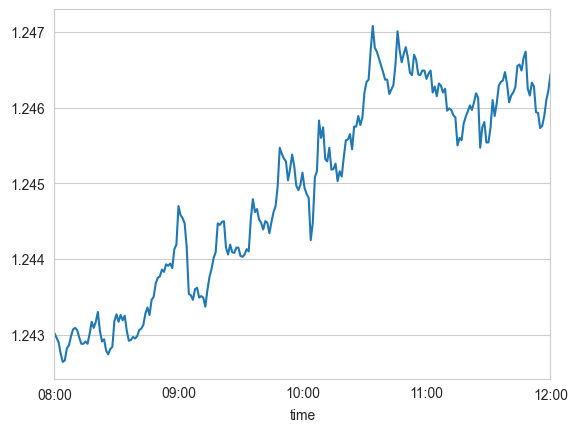

In [14]:
# Visualization of the intra-bar distribution (ideal to find new ideas by yourself)
i = 3
df.loc[data_4h.index[i]:data_4h.index[i+1]]["close"].plot()

<br>

### 2.2 Inter-Bar Features

This second type of feature is the most well-known: I call them **inter-bar features** (a name I came up with myself, as I couldn't find a conventional one online) because they use several bars to compute new features without considering intra-bar information or market trend data. These inter-bar features are basically **Technical Indicators, SMC figures, statistical indicators, chart patterns**, etc.  

In terms of horizon, they look further back than intra-bar features but not as far as over-bar features, which focus on trends and the current market regime conditions.  


In [10]:
def derivatives(df,col):
    """
    Calculates the first and second derivatives of a given column in a DataFrame 
    and adds them as new columns 'velocity' and 'acceleration'.

    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame containing the column for which derivatives are to be calculated.
        
    col : str
        The column name for which the first and second derivatives are to be calculated.

    Returns:
    --------
    df_copy : pandas.DataFrame
        A new DataFrame with 'velocity' and 'acceleration' columns added.

    """
    
    df_copy = df.copy()

    df_copy["velocity"] = df_copy[col].diff().fillna(0)
    df_copy["acceleration"] = df_copy["velocity"].diff().fillna(0)
    
    return df_copy

<Axes: xlabel='time'>

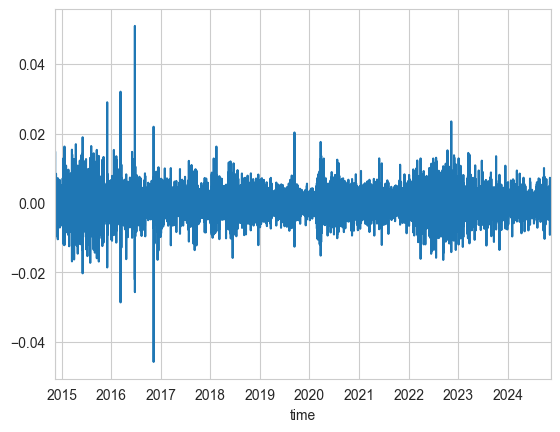

In [11]:
data_4h = derivatives(data_4h,"close")
data_4h["acceleration"].plot()

In [12]:
data_4h = data_4h.dropna()
data_4h = derivatives(data_4h, "close")
data_4h = DC_market_regime(data_4h, 0.015)
data_4h = spread(data_4h)
data_4h = kama_market_regime(data_4h, "close", 30, 100)
data_4h = gap_detection(data_4h)
for i in [1,2,5,10,20,50]:
    data_4h = auto_corr(data_4h, "close", n=100, lag=i)
for i in [1,2,5,10,20,50]:
    data_4h = log_transform(data_4h, "close", i)
data_4h = candle_information(data_4h)
data_4h = moving_yang_zhang_estimator(data_4h, 20)

In [13]:
data_4h

,open,high,low,close,tick_volume,high_time,low_time,hurst,0_to_20,20_to_40,...,ret_log_1,ret_log_2,ret_log_5,ret_log_10,ret_log_20,ret_log_50,candle_way,filling,amplitude,rolling_volatility_yang_zhang
time,,,,,,,,,,,,,,,,,,,,,
2014-11-14 00:00:00,1.24750,1.24789,1.24588,1.24665,14537,2014-11-14 00:12:00,2014-11-14 03:09:00,0.606340,12.446352,23.175966,...,NaN,NaN,NaN,NaN,NaN,NaN,-1,0.422886,0.068159,NaN
2014-11-14 04:00:00,1.24665,1.24669,1.24266,1.24307,17128,2014-11-14 04:00:00,2014-11-14 07:46:00,0.710822,12.552301,12.970711,...,-0.013045,NaN,NaN,NaN,NaN,NaN,-1,0.888337,0.287583,NaN
2014-11-14 08:00:00,1.24306,1.24711,1.24262,1.24623,35033,2014-11-14 10:34:00,2014-11-14 08:04:00,0.583402,22.500000,15.000000,...,0.011668,-0.001528,NaN,NaN,NaN,NaN,1,0.706013,0.254691,NaN
2014-11-14 12:00:00,1.24614,1.24686,1.23982,1.24140,41784,2014-11-14 12:02:00,2014-11-14 15:36:00,0.593497,5.000000,7.500000,...,-0.017641,-0.006179,NaN,NaN,NaN,NaN,-1,0.673295,0.381099,NaN
2014-11-14 16:00:00,1.24140,1.25435,1.24054,1.25140,74087,2014-11-14 19:17:00,2014-11-14 16:05:00,0.682967,25.416667,11.250000,...,0.037103,0.018807,NaN,NaN,NaN,NaN,1,0.724113,0.802311,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-13 04:00:00,1.06277,1.06290,1.06092,1.06127,3868,2024-11-13 04:00:00,2024-11-13 07:22:00,0.553327,7.916667,15.000000,...,-0.023200,-0.015591,-0.020171,-0.052179,-0.229451,-0.295852,-1,0.757576,0.141240,0.002015
2024-11-13 08:00:00,1.06127,1.06295,1.05931,1.06266,7587,2024-11-13 11:55:00,2024-11-13 10:09:00,0.541830,3.750000,33.333333,...,0.022011,-0.001700,0.006233,-0.033054,-0.197266,-0.279098,1,0.381868,0.130889,0.001949
2024-11-13 12:00:00,1.06265,1.06539,1.06097,1.06362,12339,2024-11-13 15:30:00,2024-11-13 13:31:00,0.549468,31.250000,25.000000,...,0.014858,0.037196,0.047489,-0.027691,-0.180218,-0.261703,1,0.219457,0.091240,0.002024


<br>

### 2.3 Over-Bar Features

The last type of feature is the **over-bar feature**, also called **structural features** (a name I came up with myself, as I couldn't find a conventional one online). This type of feature is designed to filter out a lot of noise and retain only the market trend or significant correlations between several markets over a minimum period of 1 month. It provides an overview of the market but does not help with precise timing for entering a position.  

These features can be very useful for **identifying different market conditions** to analyze the performance of trading strategies: Is it more profitable in a bull market, bear market, or volatile market? You can integrate one or a very small number of these features in your short-term analysis, but a short-term trading strategy should never rely solely on them.  

In [14]:
from sklearn.linear_model import LinearRegression

# Function to calculate the slope of the linear regression
def linear_regression_slope_market_trend(series):
    X = np.arange(len(series)).reshape(-1, 1)  # Create an array of indices for X
    y = series.values.reshape(-1, 1)  # Use the values of the series as y
    model = LinearRegression().fit(X, y)  # Fit the linear regression model
    slope = model.coef_[0][0]  # Extract the slope from the model
    return slope

data_4h['linear_slope_6M'] = data_4h["close"].rolling(125*6).apply(linear_regression_slope_market_trend)
data_4h['linear_slope_3M'] = data_4h["close"].rolling(60*6).apply(linear_regression_slope_market_trend)
data_4h['linear_slope_1M'] = data_4h["close"].rolling(20*6).apply(linear_regression_slope_market_trend)

data_4h

,open,high,low,close,tick_volume,high_time,low_time,hurst,0_to_20,20_to_40,...,ret_log_10,ret_log_20,ret_log_50,candle_way,filling,amplitude,rolling_volatility_yang_zhang,linear_slope_6M,linear_slope_3M,linear_slope_1M
time,,,,,,,,,,,,,,,,,,,,,
2014-11-14 00:00:00,1.24750,1.24789,1.24588,1.24665,14537,2014-11-14 00:12:00,2014-11-14 03:09:00,0.606340,12.446352,23.175966,...,NaN,NaN,NaN,-1,0.422886,0.068159,NaN,NaN,NaN,NaN
2014-11-14 04:00:00,1.24665,1.24669,1.24266,1.24307,17128,2014-11-14 04:00:00,2014-11-14 07:46:00,0.710822,12.552301,12.970711,...,NaN,NaN,NaN,-1,0.888337,0.287583,NaN,NaN,NaN,NaN
2014-11-14 08:00:00,1.24306,1.24711,1.24262,1.24623,35033,2014-11-14 10:34:00,2014-11-14 08:04:00,0.583402,22.500000,15.000000,...,NaN,NaN,NaN,1,0.706013,0.254691,NaN,NaN,NaN,NaN
2014-11-14 12:00:00,1.24614,1.24686,1.23982,1.24140,41784,2014-11-14 12:02:00,2014-11-14 15:36:00,0.593497,5.000000,7.500000,...,NaN,NaN,NaN,-1,0.673295,0.381099,NaN,NaN,NaN,NaN
2014-11-14 16:00:00,1.24140,1.25435,1.24054,1.25140,74087,2014-11-14 19:17:00,2014-11-14 16:05:00,0.682967,25.416667,11.250000,...,NaN,NaN,NaN,1,0.724113,0.802311,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-13 04:00:00,1.06277,1.06290,1.06092,1.06127,3868,2024-11-13 04:00:00,2024-11-13 07:22:00,0.553327,7.916667,15.000000,...,-0.052179,-0.229451,-0.295852,-1,0.757576,0.141240,0.002015,0.000021,-0.000124,-0.000117
2024-11-13 08:00:00,1.06127,1.06295,1.05931,1.06266,7587,2024-11-13 11:55:00,2024-11-13 10:09:00,0.541830,3.750000,33.333333,...,-0.033054,-0.197266,-0.279098,1,0.381868,0.130889,0.001949,0.000021,-0.000125,-0.000122
2024-11-13 12:00:00,1.06265,1.06539,1.06097,1.06362,12339,2024-11-13 15:30:00,2024-11-13 13:31:00,0.549468,31.250000,25.000000,...,-0.027691,-0.180218,-0.261703,1,0.219457,0.091240,0.002024,0.000020,-0.000126,-0.000125


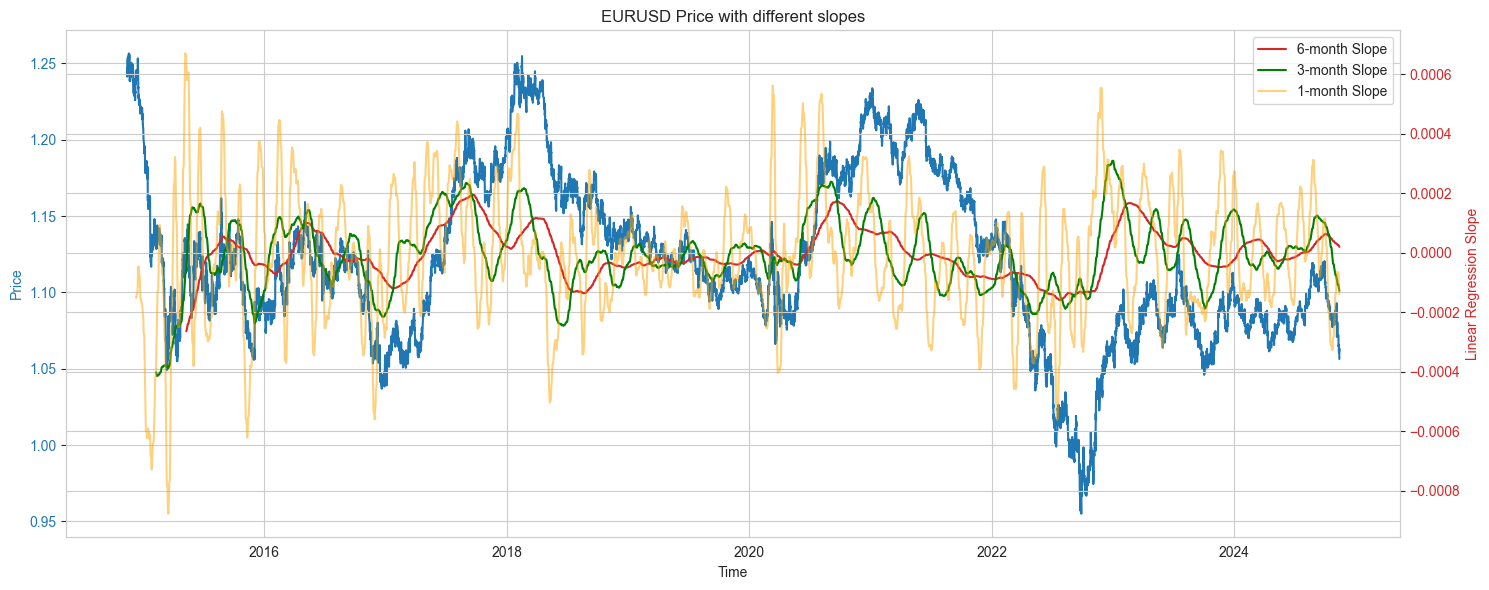

In [15]:
# Create figure and axes
fig, ax1 = plt.subplots(figsize=(15, 6))

# Plot of first data series (Price)
color = 'tab:blue'
ax1.set_xlabel('Time')
ax1.set_ylabel('Price', color=color)
ax1.plot(data_4h['close'], color=color, label='Close Price')
ax1.tick_params(axis='y', labelcolor=color)

# Creation of the second axis for the LR slopes
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Linear Regression Slope', color=color)
ax2.plot(data_4h['linear_slope_6M'], color=color, label='6-month Slope')
ax2.plot(data_4h['linear_slope_3M'], color="green", label='3-month Slope')
ax2.plot(data_4h['linear_slope_1M'], color="orange", label='1-month Slope', alpha=0.50)
ax2.tick_params(axis='y', labelcolor=color)


# Add title and display caption
plt.title('EURUSD Price with different slopes')
fig.tight_layout()
plt.legend()

# Graph display
plt.show()

In [16]:
# Save the data in order to use it later
data_4h.to_parquet("DATA/EURUSD_4H_dataset.parquet", engine='fastparquet', compression="gzip")

### It is your turn !
Try to create a new Feature and share it into the community!